In [1]:
import torch
from scipy.sparse.linalg import LaplacianNd
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torchcfm.fourier_transform import NaiveGridFourierTransform, grid_laplacian_eigenpairs

# Compute the Laplacian and visualise eigenvectors

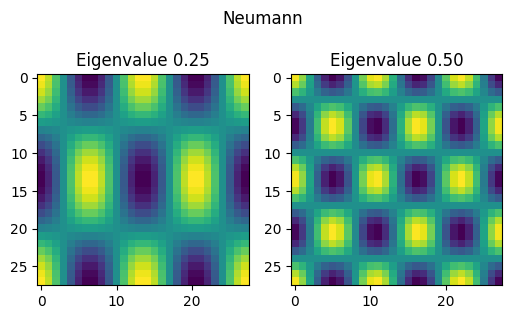

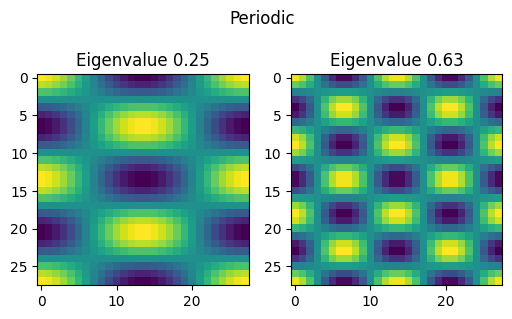

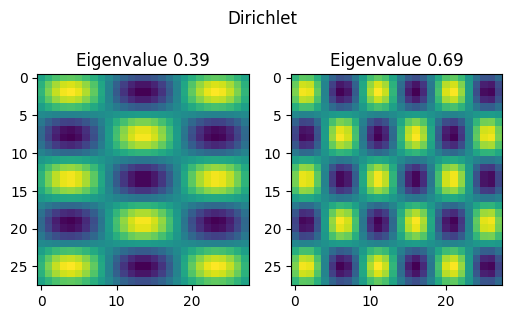

In [2]:
N_ROWS = 28
N_COLS = 28
BOUNDARY_CONDITIONS = ['neumann', 'periodic', 'dirichlet']
EIGENIDX = [20, 40]

for boundary_conditions in BOUNDARY_CONDITIONS:
    eigvecs, eigvals = grid_laplacian_eigenpairs((N_ROWS, N_COLS), boundary_conditions=boundary_conditions)
    fig, axs = plt.subplots(1, 2, figsize=(6, 3.5))
    for ax, eigidx in zip(axs, EIGENIDX):
        c = eigvecs[:, eigidx].reshape(N_ROWS, N_COLS)
        ax.imshow(c)
        ax.set_title(f'Eigenvalue {eigvals[eigidx]:.2f}')
    fig.suptitle(boundary_conditions.capitalize())
    plt.show()

# MNIST fourier transform

In [3]:
trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

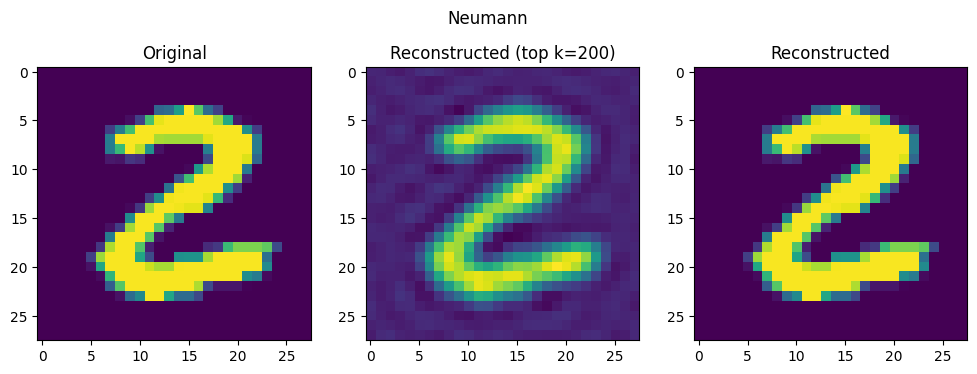

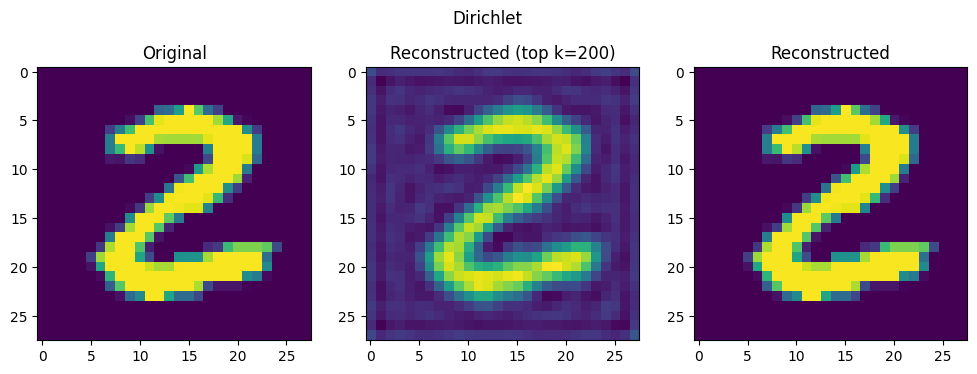

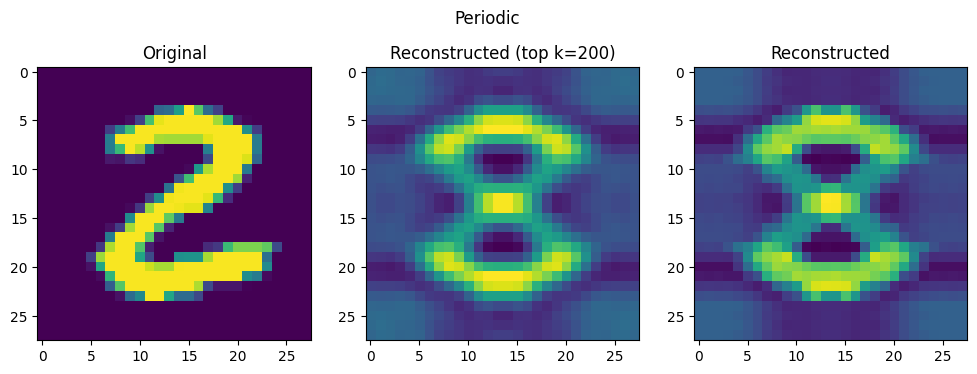

In [32]:
x = trainset[25][0][0]
shape = x.shape

for boundary_conditions in ['neumann', 'dirichlet', 'periodic']:
    k = 200

    eigvecs, eigvals = grid_laplacian_eigenpairs(shape, boundary_conditions=boundary_conditions)
    ft_full = NaiveGridFourierTransform(shape, eigvecs)
    ft_partial = NaiveGridFourierTransform(shape, eigvecs[:, :k])

    x_hat_partial = ft_partial.inverse_transform(ft_partial.transform(x))
    x_hat_full = ft_full.inverse_transform(ft_full.transform(x))

    U = eigvecs.mT[:k]
    x_hat_partial = (U.mT @ (U @ x.flatten())).reshape(28, 28)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x)
    axs[1].imshow(x_hat_partial)
    axs[2].imshow(x_hat_full)

    axs[0].set_title('Original')
    axs[1].set_title(f'Reconstructed (top {k=})')
    axs[2].set_title('Reconstructed')

    fig.suptitle(boundary_conditions.capitalize())

In [ ]:
x = trainset[25][0][0]
shape = x.shape

for boundary_conditions in ['neumann', 'dirichlet', 'periodic']:
    k = 200

    eigvecs, eigvals = grid_laplacian_eigenpairs(shape, boundary_conditions=boundary_conditions)
    ft_full = NaiveGridFourierTransform(shape, eigvecs)
    ft_partial = NaiveGridFourierTransform(shape, eigvecs[:, :k])

    x_hat_partial = ft_partial.inverse_transform(ft_partial.transform(x))
    x_hat_full = ft_full.inverse_transform(ft_full.transform(x))

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(x)
    axs[1].imshow(x_hat_partial)
    axs[2].imshow(x_hat_full)

    axs[0].set_title('Original')
    axs[1].set_title(f'Reconstructed (top {k=})')
    axs[2].set_title('Reconstructed')

    fig.suptitle(boundary_conditions.capitalize())

RuntimeError: einsum(): subscript j has size 28 for operand 1 which does not broadcast with previously seen size 200

In [ ]:
with torch.no_grad():
    traj = node.trajectory(
        torch.randn(100, 1, 28, 28, device=device),
        t_span=torch.linspace(0, 1, 2, device=device),
    )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

KeyboardInterrupt: 

# Simplify $u$ expression

In [5]:
import sympy as sp


c, l, y0, y1, t = sp.symbols('c, l, y0, y1, t')

def sigma(t):
    return - (sp.exp(-2 * c * l * t) - 1) / (2 * c * l)

def m(t, y):
    return sp.exp(-c * l * t) * y

def my1(t, y):
    return m(t, y) + sp.exp(-c * l * (1 - t)) * sigma(t) / sigma(1) * (y1 - m(1, y0))


def u(t, y):
    return sp.exp(-c * l * (1 - t)) / sigma(1 - t) * (y1 - m(1 - t, y))

In [6]:
sp.simplify(my1(t, y0))

-(-y0*(exp(2*c*l) - 1) + (y0 - y1*exp(c*l))*(exp(2*c*l*t) - 1))*exp(-c*l*t)/(exp(2*c*l) - 1)

In [7]:
sp.simplify(u(t, my1(t, y0)))

-2*c*l*(y0 - y1*exp(c*l))*exp(c*l*t)/(exp(2*c*l) - 1)

# Verify implementation of ConditionalTopologicalFlowMatcher

In [8]:
from torchcfm.conditional_flow_matching import ConditionalTopologicalFlowMatcher
from torchcfm.fourier_transform import Naive1DFourierTransform
torch.set_default_dtype(torch.float64)



def euler_method(x0, vt, ts):
    xs = [x0]
    x, t, dt = x0, 0.0, None
    for vt_current, t_next in zip(vt, ts[1:]):
        dt = t_next - t
        x = x + vt_current * dt
        xs.append(x)
        t = t_next
    return torch.stack(xs)


In [9]:
eigvecs = torch.eye(2)
eigvals = torch.tensor([1.0, 1.0])
c = 2.0
ft = Naive1DFourierTransform(eigvecs)
cfm = ConditionalTopologicalFlowMatcher(c=c, eigenvalues=eigvals, eigenvectors=eigvecs, fourier_transform=ft)

In [10]:
n = 10000
x0 = torch.tensor([[2.0, -1.0]]).expand(n, -1)
x1 = torch.tensor([[4.0, 1.0]]).expand(n, -1)
t = torch.linspace(0.0, 1.0, n)

# spectral computations 
y0, y1 = ft.transform(x0), ft.transform(x1)
yt = cfm._bridge_m(y0, y1, t)
yt_unconditional = cfm._m(y0, t)
sigmat_unconditional = cfm._sigma_tilde(t)
bt = cfm._b(yt, t)
ut = cfm._bridge_u(y0, y1, t, yt)
dyt = bt + ut 

yt_pred = y0.expand(t.shape[0], -1).clone()
yt_pred[1:] += torch.cumsum(dyt[:-1] * (t[1:] - t[:-1]).unsqueeze(-1), dim=0)
error = torch.norm(yt - yt_pred, dim=-1)


# Convert to standard coordinates
xt, xt_pred = ft.inverse_transform(yt), ft.inverse_transform(yt_pred)

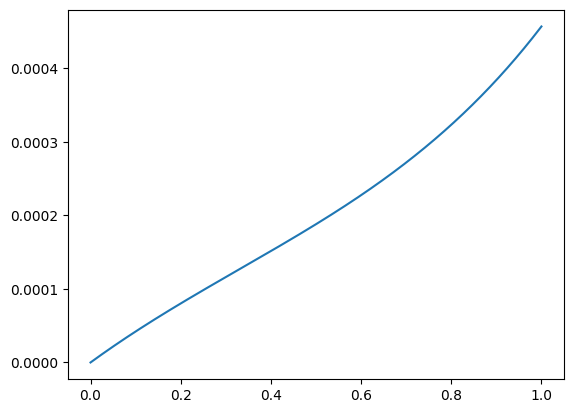

In [11]:
plt.plot(t, error)

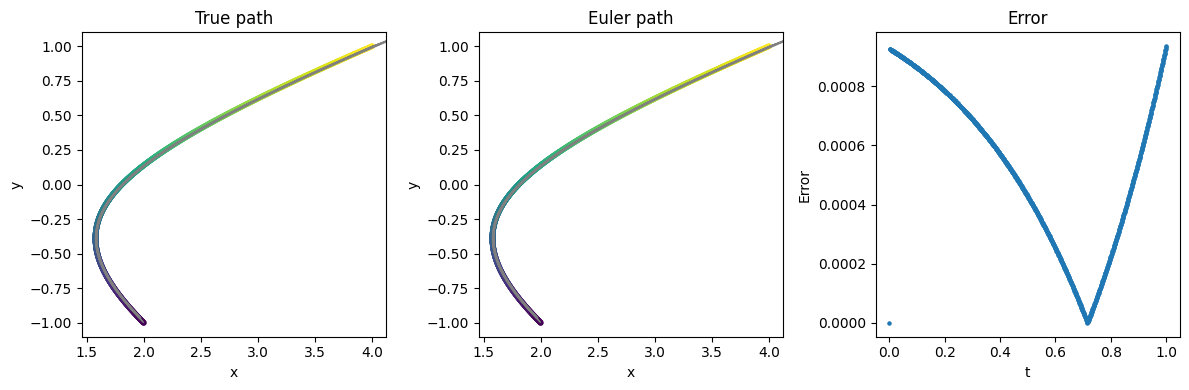

In [212]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(xt[:, 0], xt[:, 1], c=t, cmap='viridis', s=10.0)
axs[0].quiver(xt[:, 0], xt[:, 1], vt[:, 0], vt[:, 1], scale=100, width=0.003, color='grey')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].scatter(xt_pred[:, 0], xt_pred[:, 1], c=t, cmap='viridis', s=10.0)
axs[1].quiver(xt_pred[:, 0], xt_pred[:, 1], vt[:, 0], vt[:, 1], scale=100, width=0.003, color='grey')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[2].scatter(t, torch.linalg.norm(error, dim=1), s=5.0)
axs[2].set_xlabel('t')
axs[2].set_ylabel('Error')

axs[0].set_title('True path')
axs[1].set_title('Euler path')
axs[2].set_title('Error')


plt.tight_layout()

# Plot path and test integration of the velocity fields